In [5]:
from google.colab import files

try:
  files.upload("")
  print("Файл успешно импортирован")
except Exception as e:
  print(f"Во время импорта файла возникла ошибка: {e}")

Saving hotels.csv to hotels.csv
Файл успешно импортирован


+ ID	Уникальный идентификатор брони
+ n_adults	Количество взрослых
+ n_children	Количество детей
+ weekend_nights	Количество забронированных ночей (суббота–воскресенье)
+ week_nights	Количество забронированных ночей (понедельник–пятница)
+ meal_plan	План питания
+ car_parking_space	Требуется ли парковка? (0 — нет, 1 — да)
+ room_type	Тип номера
+ lead_time	Количество дней между датой бронирования и датой прибытия
+ year	Год заселения
+ month	Месяц заселения
+ date	День заселения
+ market_segment	Тип бронирования (онлайн/оффлайн)
+ repeated_guest	Постоянный гость? (0 — нет, 1 — да)
+ previous_cancellations	Количество предыдущих заказов, которые были отменены клиентом до текущего бронирования
+ previous_bookings_not_canceled	Количество предыдущих заказов, не отмененных клиентом до текущего бронирования
+ avg_room_price	Средняя цена в день бронирования
+ special_requests	Общее количество специальных запросов, сделанных клиентом
+ status	Флаг, указывающий, было ли бронирование отменено или нет


In [ ]:
!pip install pyspark

### **1. cоздать таблицу**

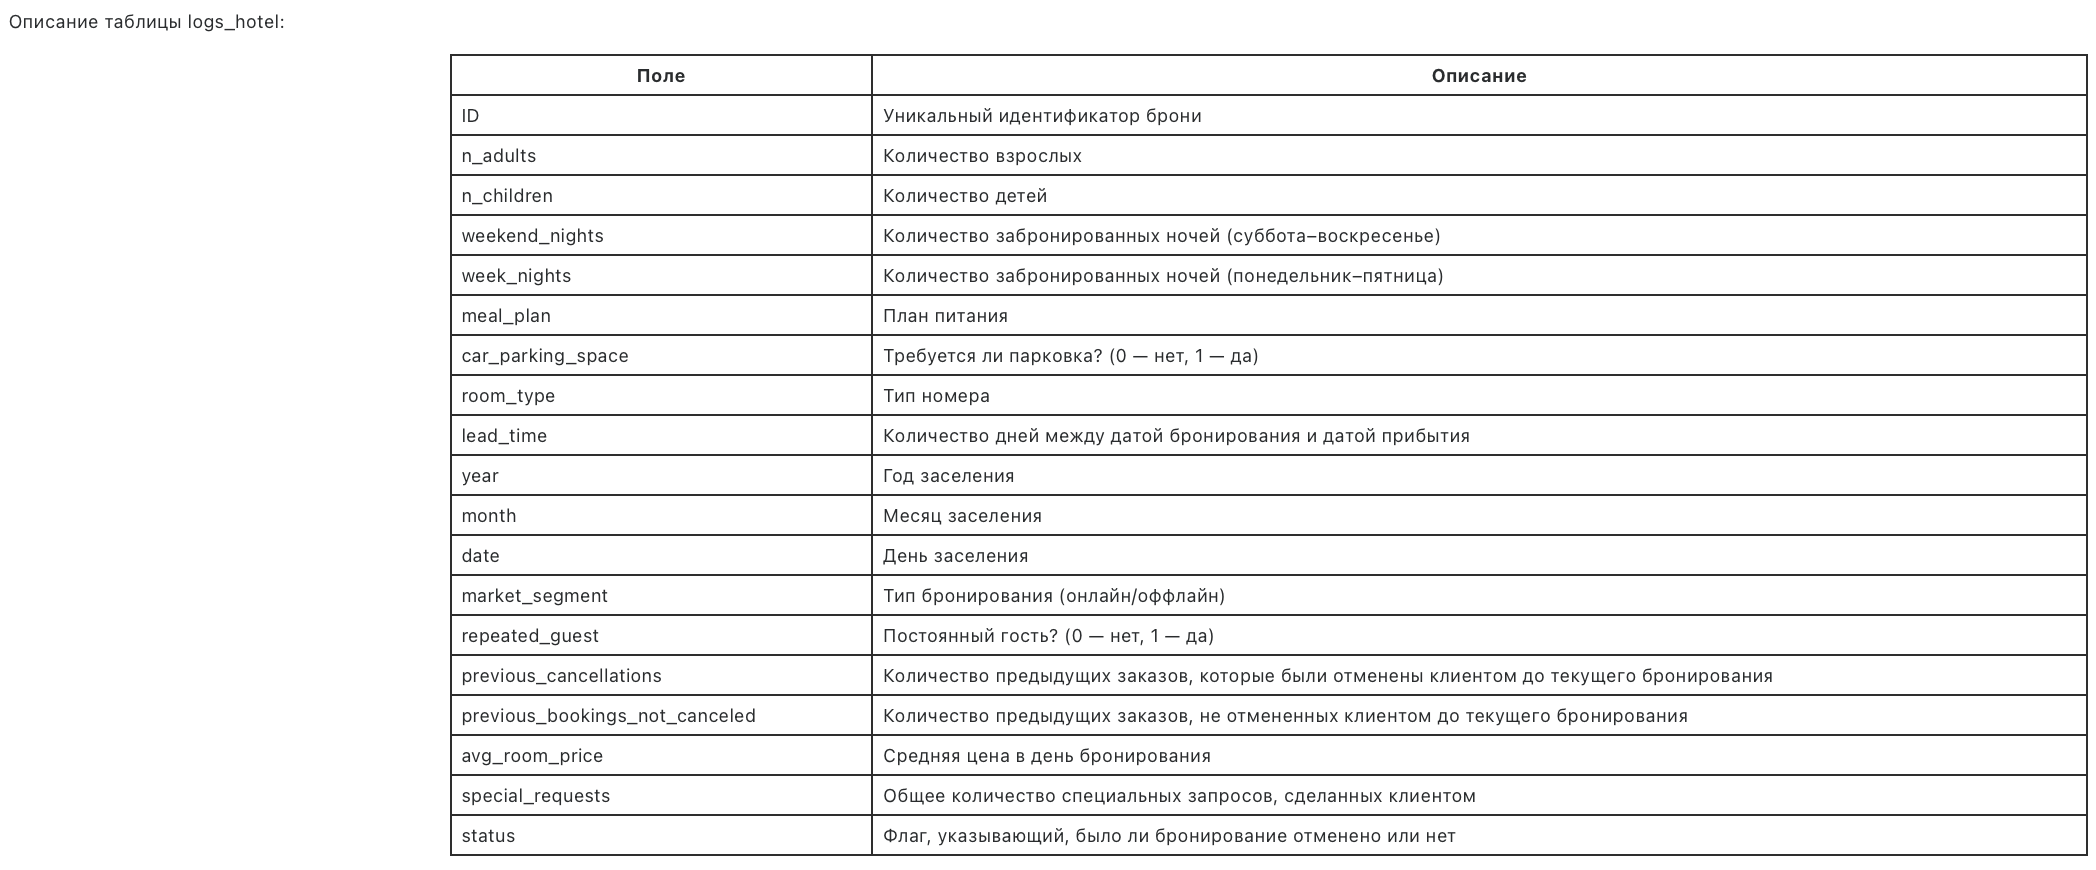

In [7]:
from pyspark.sql import SparkSession

# инициализация менеджера spark-сессии
my_spark = SparkSession.builder.master("local[*]").appName('Hotels analytics').getOrCreate()

In [8]:
import pandas as pd
from pyspark.sql.types import *

# описываю типы данных полей

hotels_attributes_schema = [
    StructField("ID",StringType(), True),
    StructField("n_adults",IntegerType(), True),
    StructField("n_children",IntegerType(), True),
    StructField("weekend_nights", IntegerType(), True),
    StructField("week_nights", IntegerType(), True),
    StructField("meal_plan", StringType(), True),
    StructField("car_parking_space", StringType(), True),
    StructField("room_type", StringType(), True),
    StructField("lead_time", IntegerType(), True),
    StructField("year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("date", IntegerType(), True),
    StructField("market_segment", StringType(), True),
    StructField("repeated_guest", IntegerType(), True),
    StructField("previuos_cancellations", IntegerType(), True),
    StructField("previuos_bookings_not_canceled", IntegerType(), True),
    StructField("avg_room_price", DoubleType(), True),
    StructField("special_requestts", IntegerType(), True),
    StructField("status", StringType(), True)
]

# создаю структуру spark-таблицы
hotels_structure = StructType(fields=hotels_attributes_schema)

# считываю данные из csv-файла
hotels_spark = my_spark.read.csv("/content/hotels.csv", sep=',', header=True, schema=hotels_structure)
hotels_spark.show()

+--------+--------+----------+--------------+-----------+------------+-----------------+-----------+---------+----+-----+----+--------------+--------------+----------------------+------------------------------+--------------+-----------------+------------+
|      ID|n_adults|n_children|weekend_nights|week_nights|   meal_plan|car_parking_space|  room_type|lead_time|year|month|date|market_segment|repeated_guest|previuos_cancellations|previuos_bookings_not_canceled|avg_room_price|special_requestts|      status|
+--------+--------+----------+--------------+-----------+------------+-----------------+-----------+---------+----+-----+----+--------------+--------------+----------------------+------------------------------+--------------+-----------------+------------+
|INN00001|       2|         0|             1|          2| Meal Plan 1|                0|Room_Type 1|      224|2017|   10|   2|       Offline|             0|                     0|                             0|          65.0|    

In [ ]:
hotels_spark.printSchema()

root
 |-- ID: string (nullable = true)
 |-- n_adults: integer (nullable = true)
 |-- n_children: integer (nullable = true)
 |-- weekend_nights: integer (nullable = true)
 |-- week_nights: integer (nullable = true)
 |-- meal_plan: string (nullable = true)
 |-- car_parking_space: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- date: integer (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- repeated_guest: integer (nullable = true)
 |-- previuos_cancellations: integer (nullable = true)
 |-- previuos_bookings_not_canceled: integer (nullable = true)
 |-- avg_room_price: double (nullable = true)
 |-- special_requestts: integer (nullable = true)
 |-- status: string (nullable = true)



### **2. cоздать таблицу**

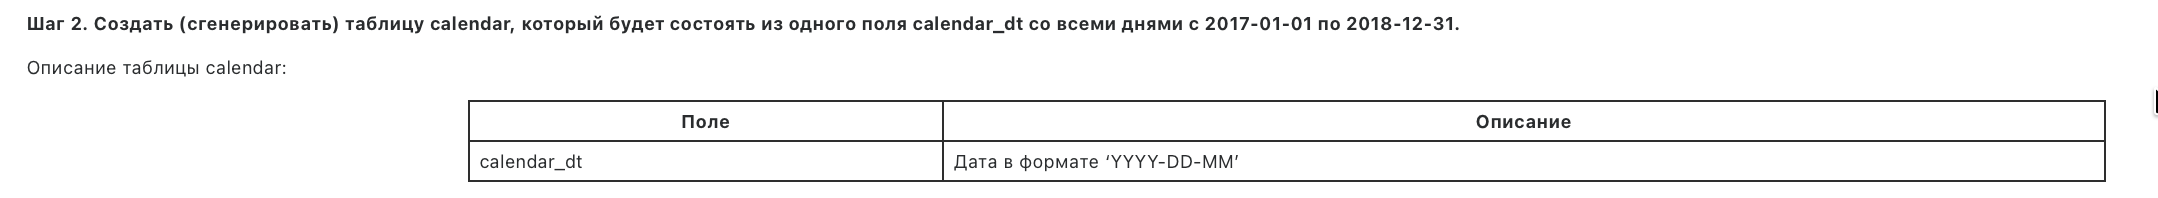

In [ ]:
import numpy as np

# cоздание таблицы calendar из под Pandas DataFrame

calendar_df = pd.DataFrame(data={'calendar_dt': np.arange("2017-01-01","2018-12-31", dtype="datetime64[D]")})
calendar_spark = my_spark.createDataFrame(data=calendar_df)
calendar_spark.show(9)

+-------------------+
|        calendar_dt|
+-------------------+
|2017-01-01 00:00:00|
|2017-01-02 00:00:00|
|2017-01-03 00:00:00|
|2017-01-04 00:00:00|
|2017-01-05 00:00:00|
|2017-01-06 00:00:00|
|2017-01-07 00:00:00|
|2017-01-08 00:00:00|
|2017-01-09 00:00:00|
+-------------------+
only showing top 9 rows


### **3. написать запросы и протестировать их**

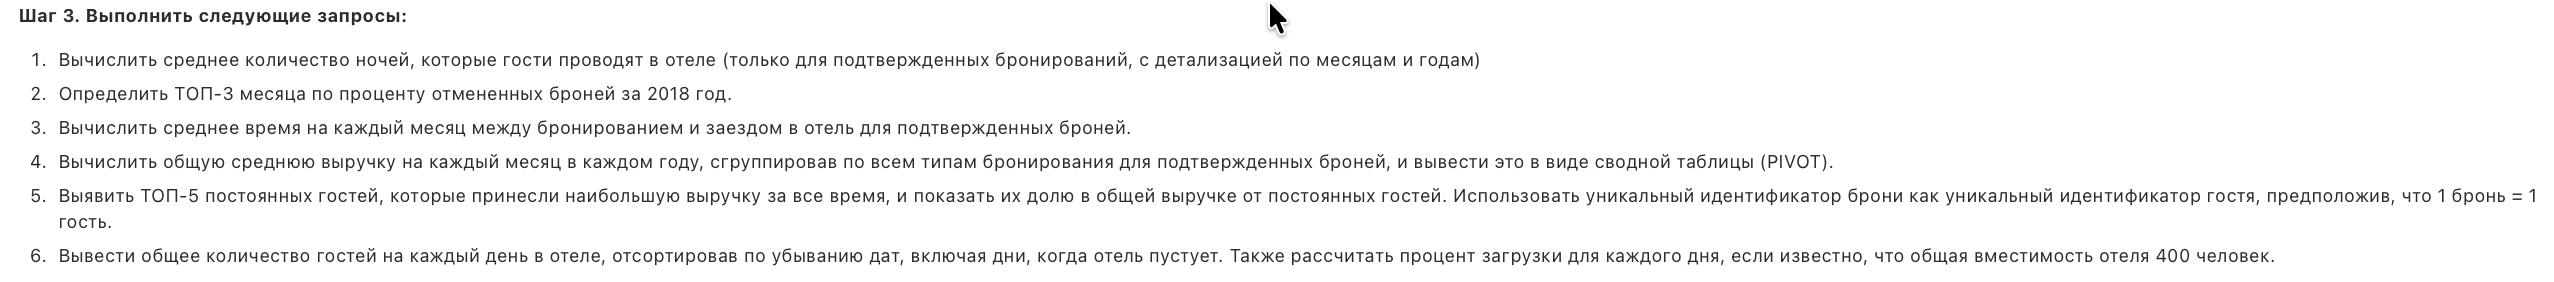

#### 3.1
> Вычислить среднее количество ночей, которые гости проводят в отеле (только для подтвержденных бронирований с детализацией по месяцам и годам)

In [ ]:
# ренейминг атрибута date в day (в человеко-понятное имя атрибута)
hotels_spark = hotels_spark.withColumnRenamed("date", "day")

# добавление расчетного атрибута "booked_total_nights"
hotels_spark = hotels_spark.withColumn('booked_total_nights', hotels_spark["week_nights"] + hotels_spark["weekend_nights"])

from pyspark.sql import functions as func

# группировка таблицы по атрибутам year, month + вычисление среднего кол-ва забронированных ночей
mean_nights_booked = hotels_spark.groupBy("year", "month").agg(func.mean("booked_total_nights").alias("mean_booked_nights"))

# сортировка таблицы по возрастанию: year, month
mean_nights_booked = mean_nights_booked.orderBy(["year", "month"], ascending=[True, True])

# округление значений атрибута mean_booked_nights до десятичного числа
mean_nights_booked = mean_nights_booked.withColumn("mean_booked_nights", func.round(func.col("mean_booked_nights"), 1))
mean_nights_booked.show()

+----+-----+------------------+
|year|month|mean_booked_nights|
+----+-----+------------------+
|2017|    7|               3.3|
|2017|    8|               2.9|
|2017|    9|               2.7|
|2017|   10|               2.7|
|2017|   11|               2.7|
|2017|   12|               3.1|
|2018|    1|               2.7|
|2018|    2|               2.9|
|2018|    3|               3.2|
|2018|    4|               3.0|
|2018|    5|               3.0|
|2018|    6|               2.7|
|2018|    7|               3.4|
|2018|    8|               3.4|
|2018|    9|               3.0|
|2018|   10|               3.0|
|2018|   11|               3.1|
|2018|   12|               3.4|
+----+-----+------------------+



#### 3.2
> Выделить топ-3 месяца с максимальным % отмен брони в 2018 году

In [83]:
from pyspark.sql import functions as func
from pyspark.sql.functions import udf, col
from pyspark.sql.types import *

canceled_booked_2018 = hotels_spark.filter((col("year")==2018) & (col("status")=="Not_Canceled"))

# суммарное количество отмененных бронирований в 2018 году
total_num_book_canceled_2018 = hotels_spark.select("ID").count()

# группировка отмененных бронирований по месяцам 2018 года.
# Атрибут num_canceled_bookings| -- количество отменных бронирований

number_canceled_bookings_per_month_2018 = canceled_booked_2018.groupBy(col("month")).agg(func.count(col("ID")).alias("num_canceled_bookings")).orderBy("num_canceled_bookings", ascending=False)

# вычисление доли отмененных бронирований в разрезе месяцев 2018 года
# к датафрейму number_canceled_bookings_per_month_2018 применена кастомная лямбда-функция udf_calc_percent_notcancel_book

udf_calc_percent_notcancel_book = udf((lambda num: (num / total_num_book_canceled_2018)*100), DoubleType())
top_3_month_2018_by_notcanceled_bookings = number_canceled_bookings_per_month_2018.withColumn("percent_notcancel_bookings_%", func.round(udf_calc_percent_notcancel_book(col("num_canceled_bookings")), 2)).orderBy("percent_notcancel_bookings_%", ascending=False)

top_3_month_2018_by_notcanceled_bookings.select("month").show(3)

+-----+
|month|
+-----+
|    6|
|   10|
|    4|
+-----+
only showing top 3 rows


#### 3.3
> Вычислить среднее время на каждый месяц между бронированием и заездом в отель (для подтвержденных броней)

In [ ]:
# фильтрация таблицы по статусу
all_canceled_bookings = hotels_spark.filter(col("status")=="Canceled")

# вычисление среднего количества дней между бронированием и заездом в отель
mean_leadtime_days_by_months = all_canceled_bookings.groupBy(col("year"), col("month")).agg(func.mean("lead_time").alias("mean_lead_time_days"))

# округление вычисленного атрибута mean_lead_time_days до 2-х знаков
mean_leadtime_days_by_months = mean_leadtime_days_by_months.withColumn("mean_lead_time_days", func.round(col(("mean_lead_time_days")), 2))

# сортировка результирующей таблицы по возрастанию года и месяца
mean_leadtime_days_by_months = mean_leadtime_days_by_months.orderBy("year", "month", ascending=[True, True])
mean_leadtime_days_by_months.show()

+----+-----+-------------------+
|year|month|mean_lead_time_days|
+----+-----+-------------------+
|2017|    7|              155.0|
|2017|    8|              74.38|
|2017|    9|              96.76|
|2017|   10|             121.55|
|2017|   11|              60.67|
|2017|   12|             115.59|
|2018|    1|               36.0|
|2018|    2|              33.62|
|2018|    3|              56.48|
|2018|    4|              94.83|
|2018|    5|              125.8|
|2018|    6|             144.52|
|2018|    7|             146.65|
|2018|    8|             153.04|
|2018|    9|             185.74|
|2018|   10|             184.44|
|2018|   11|             149.23|
|2018|   12|             167.56|
+----+-----+-------------------+



#### 3.4
> Вычислить общую среднюю выручку на каждый месяц в каждом году, сгруппировав по всем типам бронирования для подтвержденных броней и вывести это в виде сводной таблицы (PIVOT)

In [ ]:
# фильтрация таблицы по статусу
all_canceled_bookings = hotels_spark.filter(col("status")=="Canceled")

# вывожу сводную таблицу, показывающая суммарную выручку (total_reward) отелей в разрезе года, месяцев года, типа бронирования (market_segment)
pivot_total_reward_by_year_mon_marksegment = all_canceled_bookings.select(["market_segment", "year", "month", "avg_room_price"]).groupBy("year", "month", "market_segment").agg(func.sum("avg_room_price").alias("total_reward"))

# округляю total_reward до двух знаков + сортирую таблицу по возрастанию года, месяца, типа бронирования
pivot_total_reward_by_year_mon_marksegment.withColumn("total_reward", func.round("total_reward", 2)).orderBy("year", "month", "market_segment").show()

+----+-----+--------------+------------+
|year|month|market_segment|total_reward|
+----+-----+--------------+------------+
|2017|    7|       Offline|     9009.25|
|2017|    7|        Online|    12489.32|
|2017|    8|     Corporate|      1653.4|
|2017|    8|       Offline|     5154.25|
|2017|    8|        Online|     9914.44|
|2017|    9|     Corporate|      1235.0|
|2017|    9|       Offline|     9313.52|
|2017|    9|        Online|    11181.62|
|2017|   10|     Corporate|       413.0|
|2017|   10|       Offline|    17056.28|
|2017|   10|        Online|     8858.67|
|2017|   11|     Corporate|       322.0|
|2017|   11|        Online|     1684.74|
|2017|   12|        Online|     1673.13|
|2018|    1|     Corporate|       372.0|
|2018|    1|        Online|      1475.8|
|2018|    2|     Corporate|       988.0|
|2018|    2|       Offline|     6115.61|
|2018|    2|        Online|    27168.56|
|2018|    3|     Corporate|       886.0|
+----+-----+--------------+------------+
only showing top

#### 3.5
> Найти топ-5 постоянных гостей, которые принесли наибольшую выручку за все время, и показать их долю в общей выручке от постоянных гостей. Принять правило: 1 гость = 1 бронирование

In [113]:
from pyspark.sql import functions as func
from pyspark.sql.functions import col

# таблица, описывающая ID и среднюю цену бронирования  неотмененных бронирований за все время
id_avg_room_price_df = hotels_spark.filter(col("status")=="Not_Canceled").select("ID", "avg_room_price")

# суммарная выручка по всем не отмененным бронированиям за все время
total_reward_all_time = id_avg_room_price_df.agg(sum("avg_room_price")).collect()[0][0]

# вычисление долей выручки, получаемой отелями в разрезе клиентов/ бронирований + присваивание алиаса вычисленному значению
result = id_avg_room_price_df.withColumn("avg_room_price", (id_avg_room_price_df["avg_room_price"]/total_reward_all_time * 100)).withColumnRenamed("avg_room_price","percent_reward_among_all_customers")

# округление долей выручки до 5 знаков + сортировка таблицы по убыванию долей выручки
top_5_customers = result.withColumn("percent_reward_among_all_customers", func.round(result["percent_reward_among_all_customers"], 5)).orderBy("percent_reward_among_all_customers", ascending=False).show(5)
top_5_customers

+--------+----------------------------------+
|      ID|percent_reward_among_all_customers|
+--------+----------------------------------+
|INN09462|                           0.01541|
|INN34307|                           0.01434|
|INN14774|                           0.01364|
|INN33956|                           0.01289|
|INN04151|                           0.01255|
+--------+----------------------------------+
only showing top 5 rows


#### 3.6
> Вывести общее количество гостей на каждый день в отеле, отсортировав по убыванию, дат, включая дни, когда отель пустует. Также рассчитать процент загрузки каждого дня, если известно, что общая вместимость отеля 400 человек

In [140]:
number_guests_per_date_df = hotels_spark.select("year", "month", "date", "ID").groupBy("year", "month", "date").agg(func.count("ID").alias("total_guests")).orderBy(["year", "month", "date"], ascending=[False, False, False])
load_rate_hotel_by_date_df = number_guests_per_date_df.withColumn("load_rate_%", (col("total_guests") / 400 * 100)).withColumn("load_rate_%", func.round("load_rate_%", 1))
load_rate_hotel_by_date_df.show()

+----+-----+----+------------+-----------+
|year|month|date|total_guests|load_rate_%|
+----+-----+----+------------+-----------+
|2018|   12|  31|          40|       10.0|
|2018|   12|  30|          93|       23.3|
|2018|   12|  29|         105|       26.3|
|2018|   12|  28|          84|       21.0|
|2018|   12|  27|         147|       36.8|
|2018|   12|  26|         101|       25.3|
|2018|   12|  25|          47|       11.8|
|2018|   12|  24|          55|       13.8|
|2018|   12|  23|          61|       15.3|
|2018|   12|  22|          48|       12.0|
|2018|   12|  21|          52|       13.0|
|2018|   12|  20|          39|        9.8|
|2018|   12|  19|          50|       12.5|
|2018|   12|  18|          43|       10.8|
|2018|   12|  17|          47|       11.8|
|2018|   12|  16|          86|       21.5|
|2018|   12|  15|          35|        8.8|
|2018|   12|  14|          33|        8.3|
|2018|   12|  13|          37|        9.3|
|2018|   12|  12|          35|        8.8|
+----+-----